In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib widget

In [2]:
def matrix_points(p):
    #x son los puntos sobre el eje x
    x = list(np.array(p)[:,0])
    y = list(np.array(p)[:,1])
    
    #subm_1 es la submatriz compuesta de vectores fila de x
    subm_1x = np.array(x*len(x)).reshape(len(x),len(x))
    subm_1y = np.array(y*len(y)).reshape(len(y),len(y))
    
    #subm_2 es la submatriz compuesta de vectores columna repitiendo x
    subm_2x = np.transpose(subm_1x)
    subm_2y = np.transpose(subm_1y)
    
    #xi_a es el promedio de cada punto en x con cada uno de los demas puntos
    xi_a = (subm_1x+subm_2x)/2
    eta_a = (subm_1y+subm_2y)/2
    
    #xi_d es la distancia de cada punto con cada uno de los demas puntos
    xi_d = subm_2x-subm_1x
    eta_d = subm_2y-subm_1y
    
    #vectores de las matrices xi_a y xi_d
    xi_av = list(xi_a.reshape(1,len(xi_a)**2))
    xi_dv = list(xi_d.reshape(1,len(xi_d)**2))
    eta_av = list(eta_a.reshape(1,len(eta_a)**2))
    eta_dv = list(eta_d.reshape(1,len(eta_d)**2))
    
    #matriz con todas las parejas de puntos xi_a y xi_d
    xi_m = np.transpose(np.array(xi_av+xi_dv+eta_av+eta_dv)).reshape(len(x),len(x),4)
    return xi_m

In [3]:
def GeometricPotencial_3D_00_reducido(xa, xi_a, xi_d, ya, eta_a, eta_d, za, wa, f):
    
    # plus y minus
    xi_p, xi_n = xi_a+(xi_d)/2, xi_a-(xi_d)/2
    eta_p, eta_n = eta_a+(eta_d)/2, eta_a-(eta_d)/2
    
    #---------------------------------------------------------------------------------------------
    # POZOS REALES
    
    # -constants
    pic = 1 / (4*np.pi)
    k = ((2*np.pi)/wa)
    zf = za/f
    zf_comp = 1- zf
    
    # -plus contribution
    
    # --norm difference F and plus
    norm_Fplus  = np.sqrt((xi_p **2) + (eta_p ** 2) + (f ** 2))
    
    # --norm s plus
    norm_Splus  = np.sqrt((( -xa + xi_p*(zf_comp) ) ** 2) + (( -ya + eta_p*(zf_comp) ) **2) + ((za) ** 2))
    
    # --norm zf(F-plus) - (z+ra-plus)
    norm_SFplus = np.sqrt( ((zf_comp*xi_p - xa) ** 2) + ((zf_comp*eta_p - ya) ** 2) )
    
    # -- cos x_plus
    cosx_plus_num   = (zf ** 2) * (norm_Fplus ** 2)  +  (norm_Splus ** 2)  -  (norm_SFplus ** 2)
    cosx_plus_denom = 2 * zf * norm_Fplus * norm_Splus
    cosx_plus       = cosx_plus_num / cosx_plus_denom
    
    # -- inclination factor plus
    kx_plus = (k*pic) * (1 + cosx_plus)
    
    # -- total plus contribution
    kx_plus_S = kx_plus / norm_Splus
    
    
    # -minus contribution
    
    # --norm difference F and minus
    norm_Fminus  = np.sqrt((xi_n **2) + (eta_n ** 2) + (f ** 2))
    
    # --norm s minus
    norm_Sminus  = np.sqrt((( -xa + xi_n*(zf_comp) ) ** 2) + (( -ya + eta_n*(zf_comp) ) **2) + ((za) ** 2))
    
    # --norm zf(F-minus) - (z+ra-minus)
    norm_SFminus = np.sqrt( ((zf_comp*xi_n - xa) ** 2) + ((zf_comp*eta_n - ya) ** 2) )
    
    # -- cos x_minus
    cosx_minus_num   = (zf ** 2) * (norm_Fminus ** 2)  +  (norm_Sminus ** 2)  -  (norm_SFminus ** 2)
    cosx_minus_denom = 2 * zf * norm_Fminus * norm_Sminus
    cosx_minus       = cosx_minus_num / cosx_minus_denom
    
    # -- inclination factor minus
    kx_minus = (k*pic) * (1 + cosx_minus)
    
    # -- total minus contribution
    kx_minus_S = kx_minus / norm_Sminus
    
    # TOTAL CONTRIBUTION
    real_well = kx_plus_S * kx_minus_S
    
    #---------------------------------------------------------------------------------------------------------
    # PHASE
    phase_argument = 1j*k*norm_Splus  - 1j*k*norm_Sminus
    phase = np.exp(phase_argument)
    
    #-------------------------------------------------------------------------------------------------------
    # KERNEL
    
    # -without focus
    kernel_0     = 2*((k**2)*(pic ** 2)) * ((za+norm_Splus)/(norm_Splus ** 2)) * ((za+norm_Sminus)/(norm_Sminus ** 2)) * phase

    # - with focus
    kernel_focus = real_well * phase
    
    # - final kernel
    kernel = np.real(kernel_focus)
    
    return kernel

def GeometricPotencial_3D_Real(xa, ya, za, p, wa,f):
    sum_r = 0
    matrix_complete = matrix_points(p)
    matrix_real = np.einsum('iij->ij', matrix_complete)
    for i in matrix_real:
        sum_r = sum_r + GeometricPotencial_3D_00_reducido(xa,i[0],i[1],ya,i[2],i[3],za,wa,f) * (za ** 2)
#         sum_r = sum_r + GeometricPotencial_3D_00_reducido(xa,i[0],i[1],ya,i[2],i[3],za,wa,f)
    return sum_r

def GeometricPotencial_3D_Virtual(xa, ya, za, p, wa,f):
    sum_v = 0
    matrix_complete = matrix_points(p)
    matrix_virtual = []
    
    for i in range(0,len(matrix_complete)):
        for j in range(0,len(matrix_complete)):
            if i != j:
                matrix_virtual.append(list(matrix_complete[i,j]))
    
    matrix_virtual = np.array(matrix_virtual)
    
    for k in matrix_virtual:
        sum_v = sum_v + GeometricPotencial_3D_00_reducido(xa,k[0],k[1],ya,k[2],k[3],za,wa,f) * (za ** 2)
#         sum_v = sum_v + GeometricPotencial_3D_00_reducido(xa,k[0],k[1],ya,k[2],k[3],za,wa,f)
    return sum_v

def GeometricPotencial_3D_reducido(xa, ya, za, p, wa,f):
    sum_t = 1*GeometricPotencial_3D_Real(xa, ya, za, p, wa,f) + 1*GeometricPotencial_3D_Virtual(xa, ya, za, p, wa,f)
    return sum_t

In [4]:
w      = 500 * (10 ** -9)
w_ref  = 500 * (10 ** -9)

points = np.array([[-3*w_ref,0],[3*w_ref,0], [0,0]])

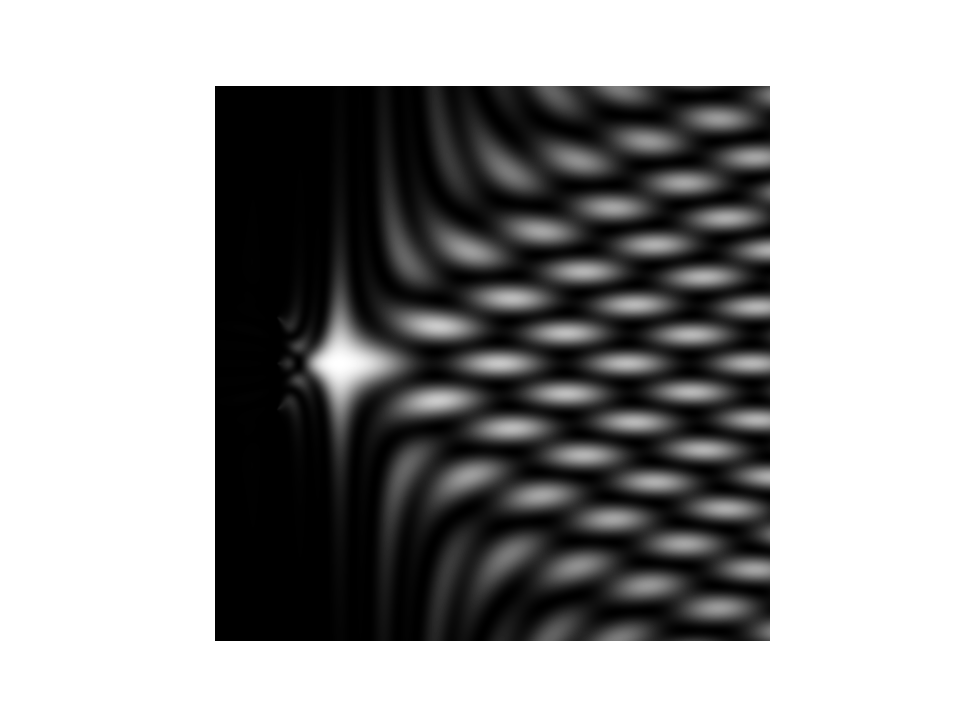

CPU times: user 434 ms, sys: 127 ms, total: 561 ms
Wall time: 555 ms


In [18]:
%%time
x1, x2 = -9, 9
z1, z2 = -2, 16
square = np.linspace(x1*w_ref, x2*w_ref, 500)
dz = np.linspace(z1*w_ref, z2*w_ref, 500)

focus = 2*w_ref

z, xx = np.meshgrid(dz, square)
zz = np.array(list(GeometricPotencial_3D_reducido(xx,0,z,points*.5,w,focus)), dtype=float)

z_mi, z_ma = zz.min()/1, zz.max()

zz = zz / z_ma

fig, (ax) = plt.subplots(dpi=150)
c = ax.imshow(zz,vmin=0, vmax=1, cmap = 'gray', 
              aspect='equal', interpolation = 'bicubic', extent=[z1*w_ref, z2*w_ref, x1*w_ref,x2*w_ref])
# fig.colorbar(c, ax = ax)
plt.axis('off')
plt.savefig("pattern_inclination_3.png")
plt.show()

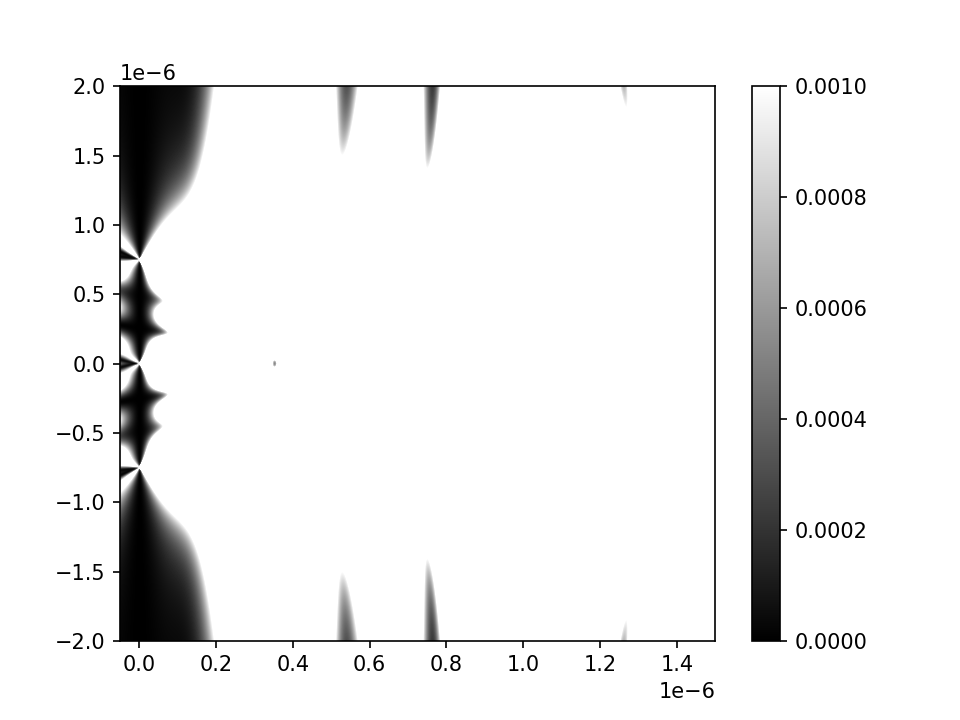

CPU times: user 539 ms, sys: 389 ms, total: 928 ms
Wall time: 663 ms


In [6]:
%%time
x1, x2 = -4, 4
z1, z2 = -.1, 3
square = np.linspace(x1*w_ref, x2*w_ref, 500)
dz = np.linspace(z1*w_ref, z2*w_ref, 500)

focus = 2*w_ref

z, xx = np.meshgrid(dz, square)
zz = np.array(list(GeometricPotencial_3D_reducido(xx,0,z,points*.5,w,focus)), dtype=float)

z_mi, z_ma = zz.min()/1, zz.max()

zz = zz / z_ma

fig, (ax) = plt.subplots(dpi=150)
c = ax.imshow(zz,vmin=0, vmax=.001, cmap = 'gray', 
              aspect='auto', interpolation = 'bicubic', extent=[z1*w_ref, z2*w_ref, x1*w_ref,x2*w_ref])
fig.colorbar(c, ax = ax)
plt.savefig("Red_670.png")
plt.show()

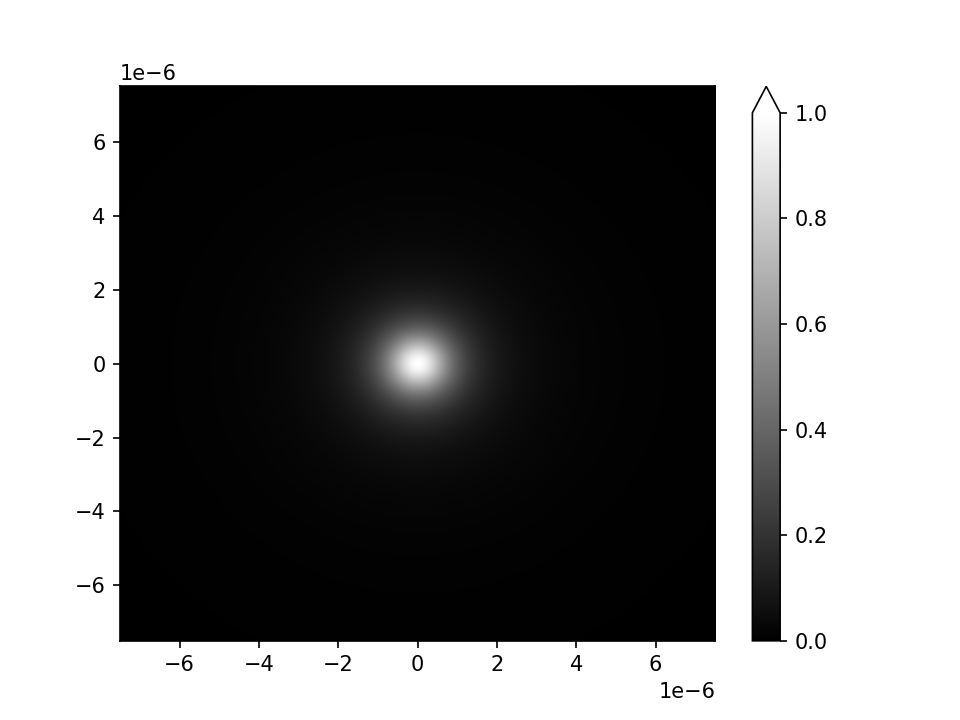

CPU times: user 371 ms, sys: 249 ms, total: 620 ms
Wall time: 484 ms


In [7]:
%%time
x1, x2 = -15, 15
square = np.linspace(x1*w, x2*w, 500)
dz = 1 * (10 ** -6)


xx, yy = np.meshgrid(square, square)
zz = np.array(list(GeometricPotencial_3D_reducido(xx, yy, dz, points*1, w,focus)), dtype=float)

z_mi, z_ma = zz.min(), zz.max()

zz = zz/ z_ma

fig, (ax) = plt.subplots(dpi=150)

c = ax.imshow(zz,vmin=0, vmax=1, cmap = 'gray', extent=[x1*w, x2*w, x1*w,x2*w], 
              aspect='auto', interpolation = 'bicubic')

fig.colorbar(c, ax=ax, extend='max')
#plt.savefig("Geometric Potencial_coherence")
plt.show()

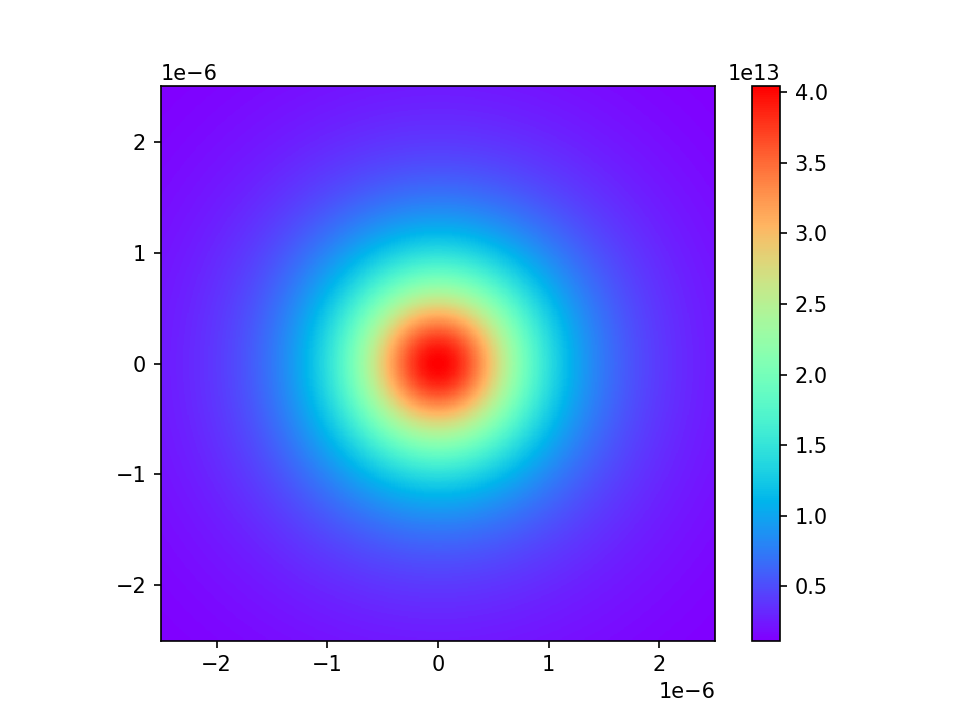

CPU times: user 463 ms, sys: 422 ms, total: 885 ms
Wall time: 567 ms


In [8]:
%%time
square = np.linspace(-5*w, 5*w, 500)
dz = 2*w

focus = 2*w

xx,yy = np.meshgrid(square, square)
zz = np.array(list(GeometricPotencial_3D_reducido(xx,yy,dz,points*1,w,focus)), dtype=float)
#zz = zz[:-1, :-1]
z_mi, z_ma = zz.min()/1, zz.max()/1

fig, (ax) = plt.subplots(dpi=150, subplot_kw={'aspect': 'equal'})
c = ax.pcolormesh(xx, yy, zz, cmap='rainbow',  vmin = z_mi, vmax = z_ma)
fig.colorbar(c, ax = ax)
#plt.savefig("Geometric Potencial_coherence")
plt.show()

In [9]:
red = cv2.imread("Red_670.png", 0)
green = cv2.imread("Green_550.png", 0)
blue = cv2.imread("Blue_450.png", 0)
merge_bgr_img = cv2.merge([blue,green,red])

In [10]:
#cv2.imwrite('RGB_foco.png', merge_bgr_img)